In [83]:
# 라이브러리 모음

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import copy 
import os 
import torch
import numpy as np
import cv2

from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152

from PIL import Image 
from torch.utils.data import Dataset 
import torchvision
import torchvision.transforms as transforms 
from torch.optim.lr_scheduler import ReduceLROnPlateau  
import torch.nn as nn 
from torchvision import utils 
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
from sklearn.metrics import classification_report
import itertools 
from tqdm.notebook import trange, tqdm 
from torch import optim
import warnings

warnings.filterwarnings('ignore')

In [84]:
IMAGE_SIZE = 256
IMAGE_CHANNEL = 3

In [85]:
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        
    def __call__(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img)
        l = self.clahe.apply(l)
        img = cv2.merge((l, a, b))
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
        return Image.fromarray(img)

class GammaCorrection:
    def __init__(self, gamma=1.0):
        self.gamma = gamma
        
    def __call__(self, img):
        img = np.array(img)
        img = img / 255.0
        img = np.power(img, self.gamma)
        img = np.uint8(img * 255)
        return Image.fromarray(img)

class ErodeTransform:
    def __init__(self, kernel_size=(3, 3), iterations=1):
        self.kernel = np.ones(kernel_size, np.uint8)
        self.iterations = iterations

    def __call__(self, img):
        img = np.array(img)
        img = cv2.erode(img, self.kernel, iterations=self.iterations)
        return Image.fromarray(img)

class DilateTransform:
    def __init__(self, kernel_size=(3, 3), iterations=1):
        self.kernel = np.ones(kernel_size, np.uint8)
        self.iterations = iterations

    def __call__(self, img):
        img = np.array(img)
        img = cv2.diate(img, self.kernel, iterations=self.iterations)
        return Image.fromarray(img)
        
class CropLargestSquareTransform:
    def __call__(self, img):
        img = np.array(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 127, cv2.THRESH_BINARY)
        
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return Image.fromarray(img)
        
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        side_length = max(w, h)
        x_center = x + w // 2
        y_center = y + h // 2
        x1 = max(x_center - side_length // 2, 0)
        y1 = max(y_center - side_length // 2, 0)
        x2 = min(x_center + side_length // 2, img.shape[1])
        y2 = min(y_center + side_length // 2, img.shape[0])
        
        img_cropped = img[y1:y2, x1:x2]
        return Image.fromarray(img_cropped)

class GaussianBlurTransform:
    def __init__(self, kernel_size=(5, 5), sigma=0):
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, img):
        # PIL 이미지를 numpy 배열로 변환
        img = np.array(img)
        
        # cv2.GaussianBlur 적용
        img = cv2.GaussianBlur(img, self.kernel_size, self.sigma)
        
        # numpy 배열을 다시 PIL 이미지로 변환
        return Image.fromarray(img)


class LaplacianTransform:
    def __init__(self):
        # 라플라시안 마스크를 정의합니다.
        self.mask = np.array([[1, 1, 1], 
                              [1, -8, 1], 
                              [1, 1, 1]])

    def __call__(self, original):
        # PIL 이미지를 numpy 배열로 변환
        img = np.array(original)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # 라플라시안 필터 적용
        laplacian = cv2.filter2D(img, -1, self.mask)
        img = cv2.cvtColor(laplacian, cv2.COLOR_GRAY2BGR)
        img = 1 - img
        # img = original * img
        # numpy 배열을 다시 PIL 이미지로 변환
        return Image.fromarray(img)
    
class OtsuThresholdTransform:
    def __call__(self, original):
        # PIL 이미지를 numpy 배열로 변환
        img = np.array(original)

        # 이미지를 그레이스케일로 변환
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # 오츠 이진화 적용
        _, otsu_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # 이진화된 이미지를 BGR로 변환 (필요한 경우)
        otsu_img_bgr = cv2.cvtColor(otsu_img, cv2.COLOR_GRAY2BGR)
        img = img - otsu_img_bgr
        # numpy 배열을 다시 PIL 이미지로 변환
        return Image.fromarray(otsu_img_bgr)

class MultiplyTransform:
    def __init__(self, factor):
        self.factor = factor
        
    def __call__(self, img):
        # 이미지를 numpy 배열로 변환
        img_np = np.array(img)
        
        # 각 값에 factor를 곱함
        img_np = img_np * self.factor
        
        # 값을 0과 255 사이로 클리핑
        img_np = np.clip(img_np, 0, 255)
        
        # 이미지로 다시 변환
        return Image.fromarray(img_np.astype(np.uint8))


# 가우시안 분포 이미지를 생성하는 함수
def create_gaussian_mask(size, sigma=0.5):
    """ size: (H, W) 형태의 튜플로 이미지 크기 설정
        sigma: 가우시안 분포의 표준편차
    """
    H, W = size
    # 가우시안 분포를 만드는 x, y 좌표계 생성
    x = np.linspace(-1, 1, W)
    y = np.linspace(-1, 1, H)
    x, y = np.meshgrid(x, y)
    
    # 2차원 가우시안 분포 계산
    d = np.sqrt(x*x + y*y)
    gaussian = np.exp(-d**2 / (2.0 * sigma**2))
    
    return gaussian


def create_doughnut_gaussian_mask(size, sigma_outer, sigma_inner):
    center = size[0] // 2, size[1] // 2
    x = np.linspace(0, size[0] - 1, size[0])
    y = np.linspace(0, size[1] - 1, size[1])
    X, Y = np.meshgrid(x, y)
    
    # Calculate distances from center
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    
    # Gaussian masks
    gaussian_outer = np.exp(-dist_from_center**2 / (2 * sigma_outer**2))
    gaussian_inner = np.exp(-dist_from_center**2 / (2 * sigma_inner**2))
    
    # Doughnut mask: subtract inner Gaussian from outer Gaussian
    doughnut_mask = gaussian_outer - gaussian_inner
    doughnut_mask = np.clip(doughnut_mask, 0, 1)
    
    return doughnut_mask


# MultiplyTransform 클래스 수정: 가우시안 분포 이미지 곱하기
class GaussianMultiplyTransform:
    def __init__(self, size, sigma=0.5):
        self.gaussian_mask = create_doughnut_gaussian_mask(size, sigma_inner=30, sigma_outer=100)
        
    def __call__(self, img):
        img_np = np.array(img).astype(np.float32)
        
        # 가우시안 마스크를 채널에 맞게 확장
        gaussian_mask = np.expand_dims(self.gaussian_mask, axis=-1)
        gaussian_mask = np.repeat(gaussian_mask, img_np.shape[-1], axis=-1)
        
        # 이미지에 가우시안 마스크 곱하기
        img_np *= gaussian_mask
        
        # 이미지를 다시 uint8로 변환
        img_np = np.clip(img_np, 0, 255).astype(np.uint8)
        return Image.fromarray(img_np)



In [86]:
transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                
        GaussianMultiplyTransform(size=(IMAGE_SIZE, IMAGE_SIZE)),  # 가우시안 분포 곱하기
        CLAHETransform(clip_limit=5.0, tile_grid_size=(8, 8)),
        GammaCorrection(gamma=0.45),
        transforms.CenterCrop(IMAGE_SIZE - 50),  # // 사용으로 정수 나누기
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),

        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [87]:
# Define object of the Train, Validation, and Test dataset.
train_set = torchvision.datasets.ImageFolder("archive/train", transform=transform) 
train_set.transform
val_set = torchvision.datasets.ImageFolder("archive/valid", transform=transform)
val_set.transform
test_set = torchvision.datasets.ImageFolder("archive/test", transform=transform)
test_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(206, 206))
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [88]:
# Visualizing some images from Trainset
CLA_label = {
        0 : 'DR',
        1 : 'No_DR',
}
def func1():
    figure = plt.figure(figsize=(10, 10))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(train_set), size=(1,)).item()
        img, label = train_set[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(CLA_label[label])
        plt.axis("off")
        img_np = img.numpy().transpose((1, 2, 0))
        # Clip pixel values to [0, 1]
        img_valid_range = np.clip(img_np, 0, 1)
        plt.imshow(img_valid_range)
        plt.suptitle('Retinopathy Images', y=0.95)
    plt.show()

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import torch
def func2():

    # 그리드 크기 설정
    rows, cols = 5, 4

    # 이미지 그리드 설정
    figure = plt.figure(figsize=(12, 12))
    for row in range(1, rows + 1):
        # 무작위로 이미지 선택
        if row == 1:
            img, label = train_set[101]
        elif row == 2:
            img, label = train_set[120]
        elif row == 3:
            img, label = train_set[38]
        elif row == 4 :
            img, label = train_set[160]
        else:
            img, label = train_set[100]

        # 무작위로 이미지 선택
        # img, label = train_set[row+2*row]

        # 이미지 numpy 배열로 변환
        img_np = img.numpy().transpose((1, 2, 0))

        # 이미지 RGB 채널 분리
        R = img_np[:, :, 0]
        G = img_np[:, :, 1]
        B = img_np[:, :, 2]

        # 각 채널 및 원본 이미지를 시각화
        figure.add_subplot(rows, cols, (row - 1) * cols + 1)
        plt.title(f"Original: {CLA_label[label]}")
        plt.axis("off")
        plt.imshow(np.clip(img_np, 0, 1))

        figure.add_subplot(rows, cols, (row - 1) * cols + 2)
        plt.title("Red Channel")
        plt.axis("off")
        plt.imshow(R, cmap="Reds")

        figure.add_subplot(rows, cols, (row - 1) * cols + 3)
        plt.title("Green Channel")
        plt.axis("off")
        plt.imshow(G, cmap="Greens")

        figure.add_subplot(rows, cols, (row - 1) * cols + 4)
        plt.title("Blue Channel")
        plt.axis("off")
        plt.imshow(B, cmap="Blues")

    plt.suptitle('Retinopathy Images and RGB Channels', y=0.92)
    plt.show()


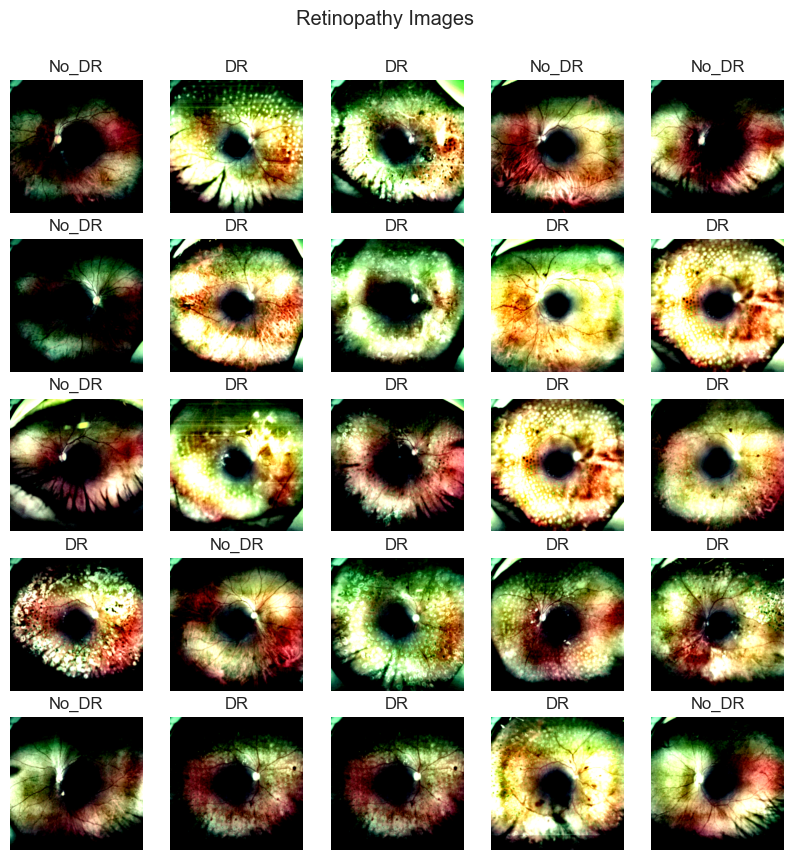

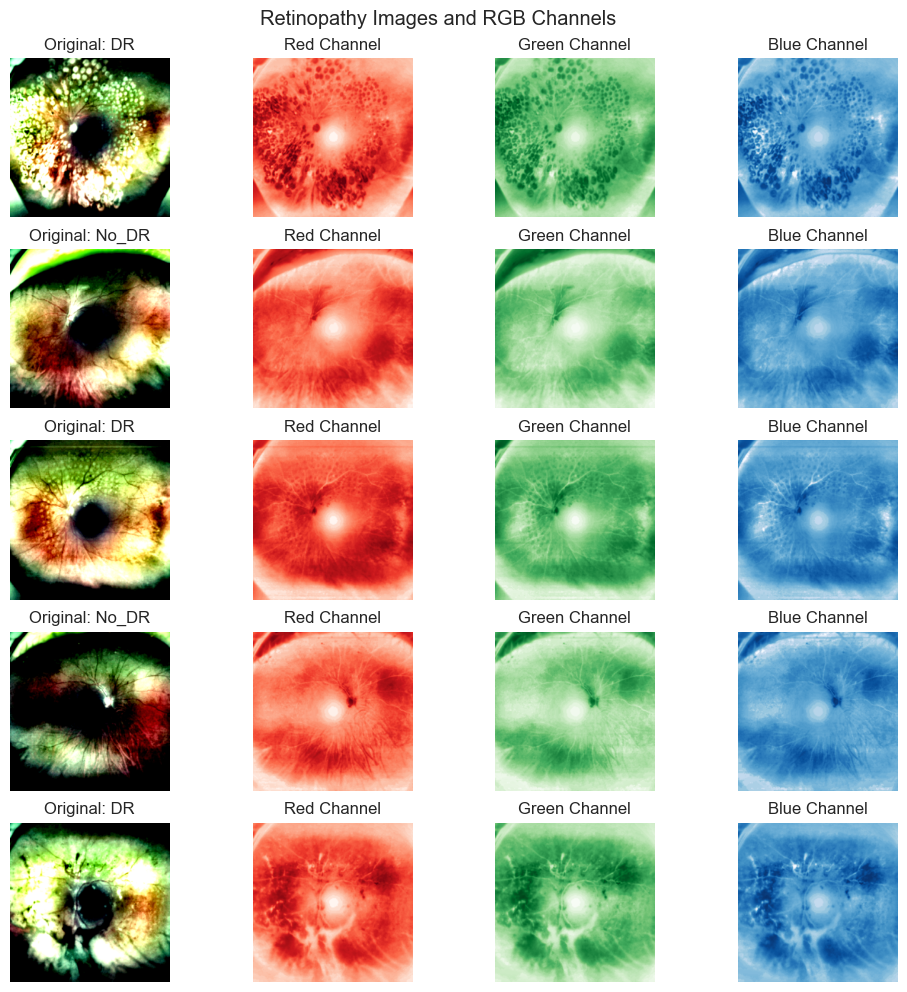

In [90]:
func1()
func2()